#### 資料前處理：將圖片切割後，分成train、valid、test三個資料夾，裡面各有12個pattern資料夾

In [2]:
import os
import time
import copy
import pymongo
import urllib
import cv2
import random
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shutil import copyfile
from PIL import Image
import shutil

## 連接 db

In [3]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
dblist = myclient.list_database_names()
print(dblist)
mydb = myclient["fashionAI"]
mycol = mydb["Products"]
print(mycol)
print(mydb)

['admin', 'config', 'fashionAI', 'local']
Collection(Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'fashionAI'), 'Products')
Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'fashionAI')


### 取出資料

In [4]:
picts_link = []
patterns = []
clothings = []

for x in mycol.find():
#     print(sorted(x.keys()))
    try:     # TODO check image
        if x["Pattern_v2"] and x["OurImage"] and x["Clothing"]:
            patterns.append(x["Pattern_v2"][0])
            picts_link.append(x["OurImage"])
            clothings.append(x["Clothing"])
    except:
        print("item image url %s has no Pattern" % (x["OurImage"],))

item image url https://bilab.synology.me/smis/brand/burton/Burton_2020-01-05_9ijawi5d.png has no Pattern
item image url https://bilab.synology.me/smis/brand/burton/Burton_2020-01-05__9080vz0.png has no Pattern
item image url https://bilab.synology.me/smis/brand/burton/Burton_2020-01-05_pshha_9c.png has no Pattern


In [5]:
# 建立url pattern 的dataframe
url_pattern_df_copy = pd.DataFrame({"image_url":picts_link, "pattern":patterns, "clothing": clothings})
url_pattern_df = copy.deepcopy(url_pattern_df_copy)
url_pattern_df['image_name'] = url_pattern_df['image_url'].apply(lambda x: x.split('/')[-1].split('.')[0])

In [6]:
# 刪除非衣服、褲子等非關注的 clothing
clothing_list = ["Short Sleeve", "Softshells", "Long Sleeve", "Windwear", "Hoodie & Sweatshirt", "Jackets & Vests",
                 "Tank", "Tops", "Sports Bra", "Polo", "Vest", "Insulated & Down", "Fleece", "Shirt", "Full-Zip,Cape",
                 "Shorts","Pants", "Leggings & Tights", "Bottoms", "Joggers", "Skirt & Dresses", "Surfing", "Rainwear", "WetSuit",
                 "Weather Protection", "Springsuit"]

print("共有 %s 筆資料不是衣服或褲子，因此不納入模型預測中" % (len(url_pattern_df) - len(url_pattern_df[url_pattern_df.apply(lambda x: bool(set(x.clothing) & set(clothing_list)), axis=1)]),))
url_pattern_df = url_pattern_df[url_pattern_df.apply(lambda x: bool(set(x.clothing) & set(clothing_list)), axis=1)]
url_pattern_df = url_pattern_df.reset_index(drop=True)
print("共剩下 %s 筆資料" % (len(url_pattern_df),))
url_pattern_df.head()


# 刪除非上面 12 種 pattern
pattern_list = ["abstract", "animal print", "camouflage", "floral", "geometric", "ikat",
                 "melange", "placement", "plaids", "solid", "spots", "strips"]

print("共有 %s 筆資料不是在目標pattern中，因此不納入模型預測中" % (len(url_pattern_df) - len(url_pattern_df[url_pattern_df['pattern'].isin(pattern_list)]),))
url_pattern_df = url_pattern_df[url_pattern_df['pattern'].isin(pattern_list)]
url_pattern_df = url_pattern_df.reset_index(drop=True)

print("共剩下 %s 筆資料" % (len(url_pattern_df),))
url_pattern_df.head()

共有 400 筆資料不是衣服或褲子，因此不納入模型預測中
共剩下 11148 筆資料
共有 785 筆資料不是在目標pattern中，因此不納入模型預測中
共剩下 10363 筆資料


image_url    pattern  \
0  https://bilab.synology.me/smis/brand/reebok/re...  placement   
1  https://bilab.synology.me/smis/brand/adidas/ad...   abstract   
2  https://bilab.synology.me/smis/brand/reebok/re...   abstract   
3  https://bilab.synology.me/smis/brand/under_arm...   abstract   
4  https://bilab.synology.me/smis/brand/adidas/ad...      spots   

                clothing             image_name  
0  [Hoodie & Sweatshirt]        reebok_kxxojml3  
1    [Leggings & Tights]        adidas_zbt4o5v_  
2    [Leggings & Tights]        reebok_t_5ziwiu  
3    [Leggings & Tights]  under_armour_u9a8s1te  
4      [Jackets & Vests]        adidas_lq_z8pdy

## EDA

#### patterns 共要預測 12 種，分別為

In [7]:
print("Pattern 共有 %s 種，分別為:" % (len(set(url_pattern_df['pattern'].unique()))))
set(url_pattern_df['pattern'].unique())

Pattern 共有 12 種，分別為:


{'abstract',
 'animal print',
 'camouflage',
 'floral',
 'geometric',
 'ikat',
 'melange',
 'placement',
 'plaids',
 'solid',
 'spots',
 'strips'}

#### pattern 中文
* 'abstract' : 抽象
* 'animal print' : 動物印花
* 'camouflage':偽裝
* 'floral':花的
* 'geometric':幾何
* 'ikat':絣織
* 'melange':混合
* 'placement':
* 'plaids':花尼格紋
* 'solid':素色
* 'spots':斑點
* 'strips':條紋

#### 看各個 pattern 圖片的長相

In [8]:
# def url_to_image(url, width=200, height=200):
#     resp = urllib.request.urlopen(url)
#     image = np.asarray(bytearray(resp.read()), dtype="uint8")
#     image = cv2.imdecode(image, cv2.IMREAD_COLOR) 
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image, (width, height))  # resize
#     return image

In [9]:
def url_to_image_original(url, width=200, height=200):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image, (width, height))  # resize
    return image

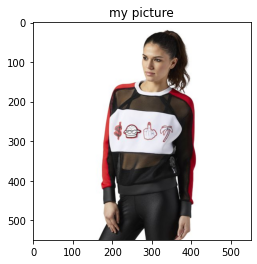

In [10]:
plt.imshow(url_to_image_original(url_pattern_df.loc[0,"image_url"]))
plt.title('my picture')
plt.show()

以下是 floral 類別的圖片


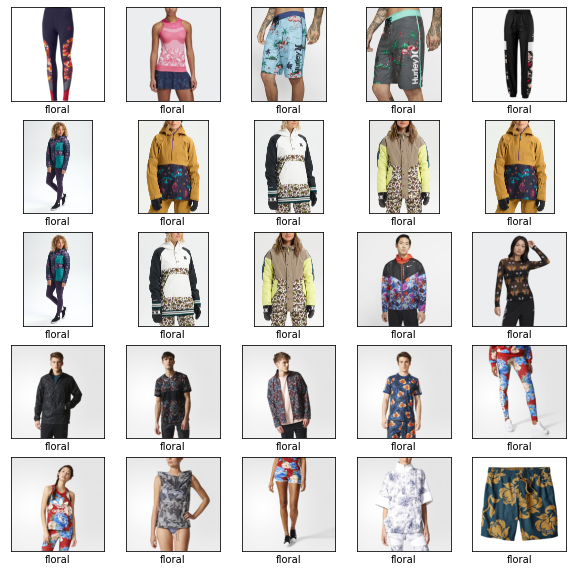

In [11]:
# 其他詳見 batchX.ipynb
current_pattern = "floral"
print("以下是 %s 類別的圖片" % (current_pattern,))
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(url_to_image_original(url_pattern_df[url_pattern_df["pattern"]==current_pattern].reset_index().loc[i,"image_url"]), cmap=plt.cm.binary)
    plt.xlabel(url_pattern_df[url_pattern_df["pattern"]==current_pattern].reset_index().loc[i,"pattern"])
plt.show()

#### 各個 pattern 圖片的數量

In [12]:
pattern = url_pattern_df.groupby("pattern")
pattern.size()

pattern
abstract        1212
animal print     192
camouflage       510
floral           509
geometric        744
ikat              18
melange         2656
placement        469
plaids           353
solid           2950
spots             38
strips           712
dtype: int64

#### 查看原始每張圖片的 shape 是多大 (TODO)

## 資料前處理

In [13]:
patterns = [
    "abstract",
    "animal print",
    "camouflage",
    "floral",
    "geometric",
    "ikat",
    "melange",
    "placement",
    "plaids",
    "solid",
    "spots",
    "strips",
]

### 嘗試依照不同服裝類別打造不同的切割方法
使用 opencv 提供的 upper body, lower body，效果不理想，先不使用。  
針對上半身:  
一開始想說針對每一種不同的 clothing 來看，例如某些 clothing 切割 刪除上下各0.2 或是各0.1，但是效果不佳，  
後來發現主要差異在於是否有頭部，由於發現 opencv 的臉部辨識似乎還可以使用，所以決定先採用。  
* 沒人臉
* 上:0.2   (之後想要改) 0.1
* 下:0.8   (之後想要改) 0.9
* 有人臉
* 上:0.3
* 下:0.8

針對下半身:  
也同時判斷是否有頭部， 如果有頭部就只從下半身開始。  
* 沒人臉
* 上:0.15
* 下:0.8
* 有人臉
* 上:0.4
* 下:0.9

針對下半身與全身有可能:  
這個群是 dresses，較為複雜，先不特別處理。

針對上半身與全身有可能:  
實測後可以併入上半身一起實做。  

完整切割照片請參閱 切割.ppt


In [14]:
face_cascade = cv2.CascadeClassifier('/home/andyyen2529/.local/lib/python3.6/site-packages/cv2/data/haarcascade_frontalface_default.xml')
# upper_cacade = cv2.CascadeClassifier('/home/andyyen2529/.local/lib/python3.6/site-packages/cv2/data/haarcascade_upperbody.xml')
# low_cascade = cv2.CascadeClassifier('/home/andyyen2529/.local/lib/python3.6/site-packages/cv2/data/haarcascade_lowerbody.xml') 

def has_face(image):  # 判斷是否有人臉
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY )
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1 , minNeighbors=5, minSize=(int(gray.shape[0]/15),int(gray.shape[1]/20)))
#     up = upper_cacade.detectMultiScale(gray, scaleFactor=1.1 , minNeighbors=5,  minSize=(int(gray.shape[0]/5),int(gray.shape[1]/8)))
#     low = low_cascade.detectMultiScale(gray, scaleFactor=1.1 , minNeighbors=5,  minSize=(int(gray.shape[0]/3),int(gray.shape[1]/8)))
#     圖片數據
#     ScaleFactor：每次搜尋方塊減少的比例
#     minNeighbers：每個目標至少檢測到幾次以上，才可被認定是真數據。
#     minSize：設定數據搜尋的最小尺寸 ，如 minSize=(40,40)

    def get_largest_part(a_list):  # 回傳最大的區塊
        if len(a_list)<2:
            return a_list
        else:
            return sorted(a_list, key=lambda x: x[2]*x[3], reverse=True)[:1]
    faces = get_largest_part(faces)
#     up = get_largest_part(up)
#     low = get_largest_part(low)
#     for (x,y,w,h) in faces:
#         cv2.rectangle(image, (x,y), (x+w, y+h), (255, 0, 0), 3)
    if faces == ():  # 如果沒有偵測到，或是偵測出來位置太低救回傳否
        return False
    elif faces[0][1] > image.shape[0] * 0.3:
        return False
    else:
        return True

#### 上半身

以下是 Short Sleeve 類別的圖經過切割之後會成為的樣子


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


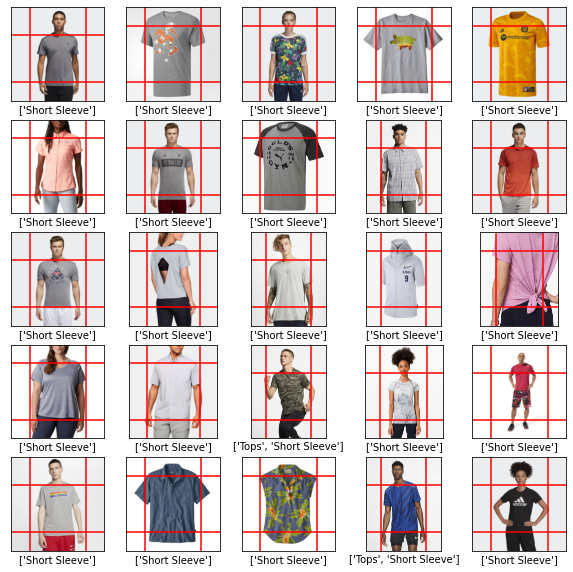

In [15]:
current_clothing = "Short Sleeve"
print("以下是 %s 類別的圖經過切割之後會成為的樣子" % (current_clothing,))
current_clothing_df = url_pattern_df[url_pattern_df.apply(lambda x: bool(set(x.clothing) & set([current_clothing])), axis=1)].reset_index()
random_clothing_indexes = random.choices(current_clothing_df.index.tolist(), k=25)
plt.figure(figsize=(10,10))

for index, i in enumerate(random_clothing_indexes):
    cur_image = url_to_image_original(current_clothing_df.loc[i,"image_url"])
    plt.subplot(5,5,index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if has_face(cur_image):
        plt.axhline(y=cur_image.shape[0] * 0.3, xmin=0, xmax=1, color='red')
        plt.axhline(y=cur_image.shape[0] * 0.8, xmin=0, xmax=1, color='red')
    else:
        plt.axhline(y=cur_image.shape[0] * 0.2, xmin=0, xmax=1, color='red')
        plt.axhline(y=cur_image.shape[0] * 0.8, xmin=0, xmax=1, color='red')
    plt.axvline(x=cur_image.shape[1] * 0.2, ymin=0, ymax=1, color='red')
    plt.axvline(x=cur_image.shape[1] * 0.8, ymin=0, ymax=1, color='red')
    plt.imshow(cur_image, cmap=plt.cm.binary)
    plt.xlabel(current_clothing_df.loc[i,"clothing"])
plt.show()

#### 下半身

以下是 Pants 類別的圖經過切割之後會成為的樣子


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


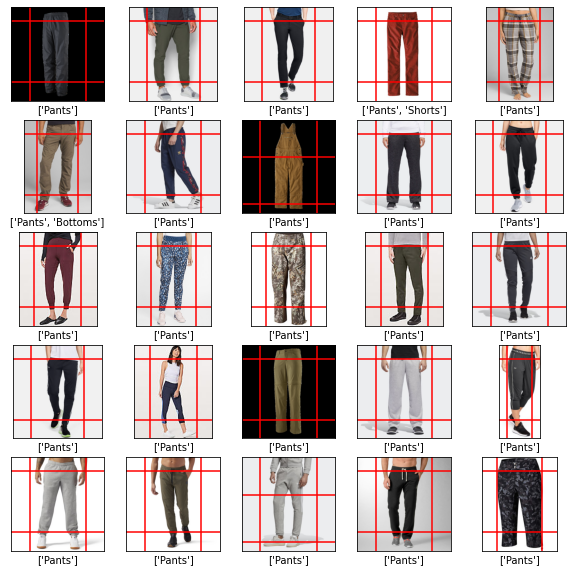

In [16]:
current_clothing = "Pants"
print("以下是 %s 類別的圖經過切割之後會成為的樣子" % (current_clothing,))
current_clothing_df = url_pattern_df[url_pattern_df.apply(lambda x: bool(set(x.clothing) & set([current_clothing])), axis=1)].reset_index()
random_clothing_indexes = random.choices(current_clothing_df.index.tolist(), k=25)
plt.figure(figsize=(10,10))

for index, i in enumerate(random_clothing_indexes):
    cur_image = url_to_image_original(current_clothing_df.loc[i,"image_url"])
    plt.subplot(5,5,index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if has_face(cur_image):
        plt.axhline(y=cur_image.shape[0] * 0.4, xmin=0, xmax=1, color='red')
        plt.axhline(y=cur_image.shape[0] * 0.9, xmin=0, xmax=1, color='red')
    else:
        plt.axhline(y=cur_image.shape[0] * 0.15, xmin=0, xmax=1, color='red')
        plt.axhline(y=cur_image.shape[0] * 0.8, xmin=0, xmax=1, color='red')
    plt.axvline(x=cur_image.shape[1] * 0.2, ymin=0, ymax=1, color='red')
    plt.axvline(x=cur_image.shape[1] * 0.8, ymin=0, ymax=1, color='red')
    plt.imshow(cur_image, cmap=plt.cm.binary)
    plt.xlabel(current_clothing_df.loc[i,"clothing"])
plt.show()

#### 針對下半身全身都有可能

In [17]:
# current_clothing = "Skirt & Dresses"
# print("以下是 %s 類別的圖經過切割之後會成為的樣子" % (current_clothing,))
# current_clothing_df = url_pattern_df[url_pattern_df.apply(lambda x: bool(set(x.clothing) & set([current_clothing])), axis=1)].reset_index()
# random_clothing_indexes = random.choices(current_clothing_df.index.tolist(), k=25)
# plt.figure(figsize=(10,10))

# for index, i in enumerate(random_clothing_indexes):
#     cur_image = url_to_image_original(current_clothing_df.loc[i,"image_url"])
#     plt.subplot(5,5,index+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     if has_face(cur_image):
#         plt.axhline(y=cur_image.shape[0] * 0.25, xmin=0, xmax=1, color='red')
#         plt.axhline(y=cur_image.shape[0] * 0.8, xmin=0, xmax=1, color='red')
#     else:
#         plt.axhline(y=cur_image.shape[0] * 0.2, xmin=0, xmax=1, color='red')
#         plt.axhline(y=cur_image.shape[0] * 0.8, xmin=0, xmax=1, color='red')
#     plt.axvline(x=cur_image.shape[1] * 0.2, ymin=0, ymax=1, color='red')
#     plt.axvline(x=cur_image.shape[1] * 0.8, ymin=0, ymax=1, color='red')
#     plt.imshow(cur_image, cmap=plt.cm.binary)
#     plt.xlabel(current_clothing_df.loc[i,"clothing"])
# plt.show()

In [18]:
def cut_image(cur_image, original_clothing):
    upper_clothing = ["Short Sleeve", "Softshells", "Long Sleeve", "Windwear", "Hoodie & Sweatshirt", "Jackets & Vests",
                     "Tank", "Tops", "Sports Bra", "Polo", "Vest", "Insulated & Down", "Fleece", "Shirt"]
    lower_clothing = ["Shorts","Pants", "Leggings & Tights", "Bottoms"]
    lower_all_clothing = ["Skirt & Dresses"]
    upper_all_clothing = ["Surfing", "Rainwear", "WetSuit", "Weather Protection", "Springsuit"]
    if bool(set(original_clothing) & set(upper_clothing)):  #上半身情況
        if has_face(cur_image):
            y_start_coefficient = 0.3
            height_coefficient = 0.5
        else:
            y_start_coefficient = 0.2
            height_coefficient = 0.6
        clothing_condition = 0
    elif bool(set(original_clothing) & set(lower_clothing)):  #下半身情況
        if has_face(cur_image):
            y_start_coefficient = 0.4
            height_coefficient = 0.5
        else:
            y_start_coefficient = 0.15
            height_coefficient = 0.65
        clothing_condition = 1
    elif bool(set(original_clothing) & set(lower_all_clothing)):  #下半身全身都有可能情況
        if has_face(cur_image):
            y_start_coefficient = 0.25
            height_coefficient = 0.55
        else:
            y_start_coefficient = 0.2
            height_coefficient = 0.6
        clothing_condition = 2
    elif bool(set(original_clothing) & set(upper_all_clothing)):  #上半身全身都有可能情況
        if has_face(cur_image):
            y_start_coefficient = 0.3
            height_coefficient = 0.5
        else:
            y_start_coefficient = 0.2
            height_coefficient = 0.6
        clothing_condition = 3
    else:
        y_start_coefficient = 0.2
        height_coefficient = 0.6
        clothing_condition = 4
        
    x_start = int(0.2 * cur_image.shape[1])
    y_start = int(y_start_coefficient * cur_image.shape[0])
    # 裁切區域的長度與寬度
    width = int(0.6 * cur_image.shape[1])
    height = int(height_coefficient * cur_image.shape[0])
    # 裁切圖片
    crop_img = cur_image[y_start:y_start+height, x_start:x_start+width]
    # 裁切完再resize
    train_images_cur = cv2.resize(crop_img, (256, 256))
    return train_images_cur, clothing_condition

### 製作新資料夾，存放裁切後的圖片
從 data_zip/image_reco 抓取圖片，去掉沒用的圖片(pattern、clothing不符的)，再裁切之後把他放到 batch1_images_cut 資料夾，並歸類到12個不同的pattern子資料夾內 (只須執行一次)

In [19]:
current_path = './data_zip/image_reco'
# batch1_cut_path = './batch1_images_cut/'
# upper_clothing_count = 0
# lower_clothing_count = 0
# lower_all_clothing_count = 0
# upper_all_clothing_count = 0
# default_count = 0
# dimension_error_count = 0
# start_time = time.time()

# # 跳錯的話可能是要先把 batch1_images_cut 檔案刪掉
# for i in patterns:
#     os.makedirs(batch1_cut_path + i)

# for index, i in url_pattern_df.iterrows():
#     if index % 500 == 0:
#         print(index)
        
#     pattern = i.pattern
#     image_name = i.image_name
#     clothing = i.clothing
#     current_file = current_path + '/' + image_name + '.png'
#     img = Image.open(current_file)
#     img_ = np.array(img)
#     if img_.ndim != 3:
#         dimension_error_count += 1
#         continue
#     if img_.shape[2] == 4:  # 處理有 Transparency (RGBA) 的情況
#         img = img.convert('RGB')
#         img_ = np.array(img)
    
#     img_, clothing_condition = cut_image(img_, clothing)
#     im = Image.fromarray(img_)
#     im.save(batch1_cut_path + pattern + '/' + image_name + '.png')
    
#     if clothing_condition == 0:
#         upper_clothing_count += 1
#     elif clothing_condition == 1:
#         lower_clothing_count += 1
#     elif clothing_condition == 2:
#         lower_all_clothing_count += 1
#     elif clothing_condition == 3:
#         upper_all_clothing_count += 1
#     elif clothing_condition == 4:
#         default_count += 1
#     else:
#         print("clothing condition has something wrong!!")
# end_time = time.time()

# print("上半身照片總數: %s" % (upper_clothing_count,))
# print("下半身照片總數: %s" % (lower_clothing_count,))
# print("下半身全身皆有可能照片總數: %s" % (lower_all_clothing_count,))
# print("上半身全身皆有可能照片總數: %s" % (upper_all_clothing_count,))
# print("不屬於以上類別使用默認切割: %s" % (default_count,))
# print("有 %s 張圖片維度錯誤，所以跳過" % (dimension_error_count,))
# print("總耗費時間: %d" % (end_time - start_time,))

切割前的圖檔:


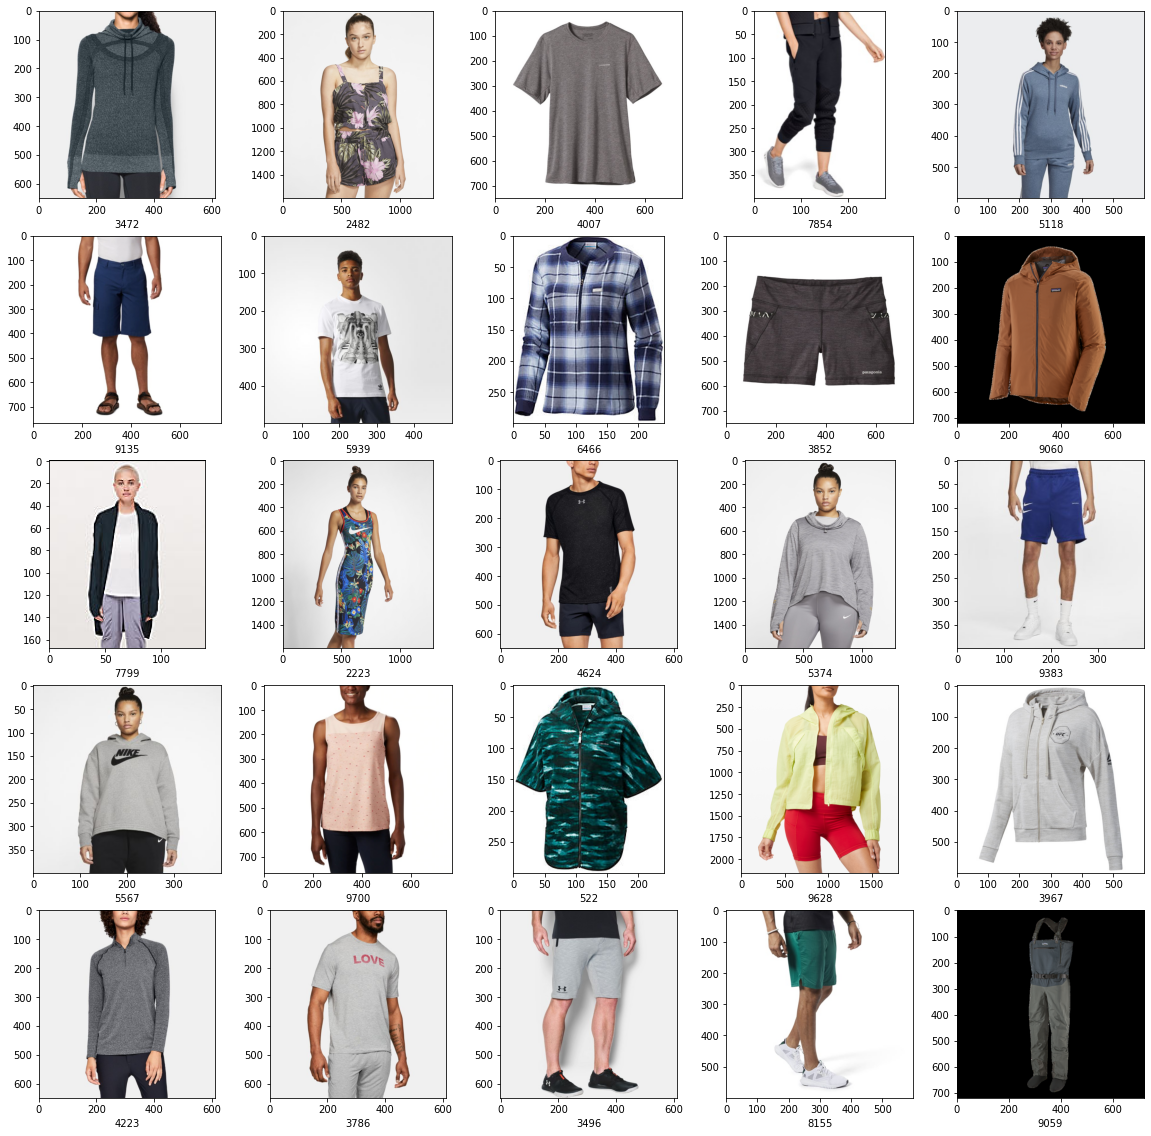

In [20]:
print("切割前的圖檔:")
randomlist = random.sample(range(0, url_pattern_df.shape[0]), 25)
plt.figure(figsize=(20,20))
for i, df_index in enumerate(randomlist):
    plt.subplot(5,5,i+1)
    plt.imshow(url_to_image_original(url_pattern_df.loc[df_index,'image_url']))
    plt.xlabel(df_index)
plt.show()

切割後的圖檔:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


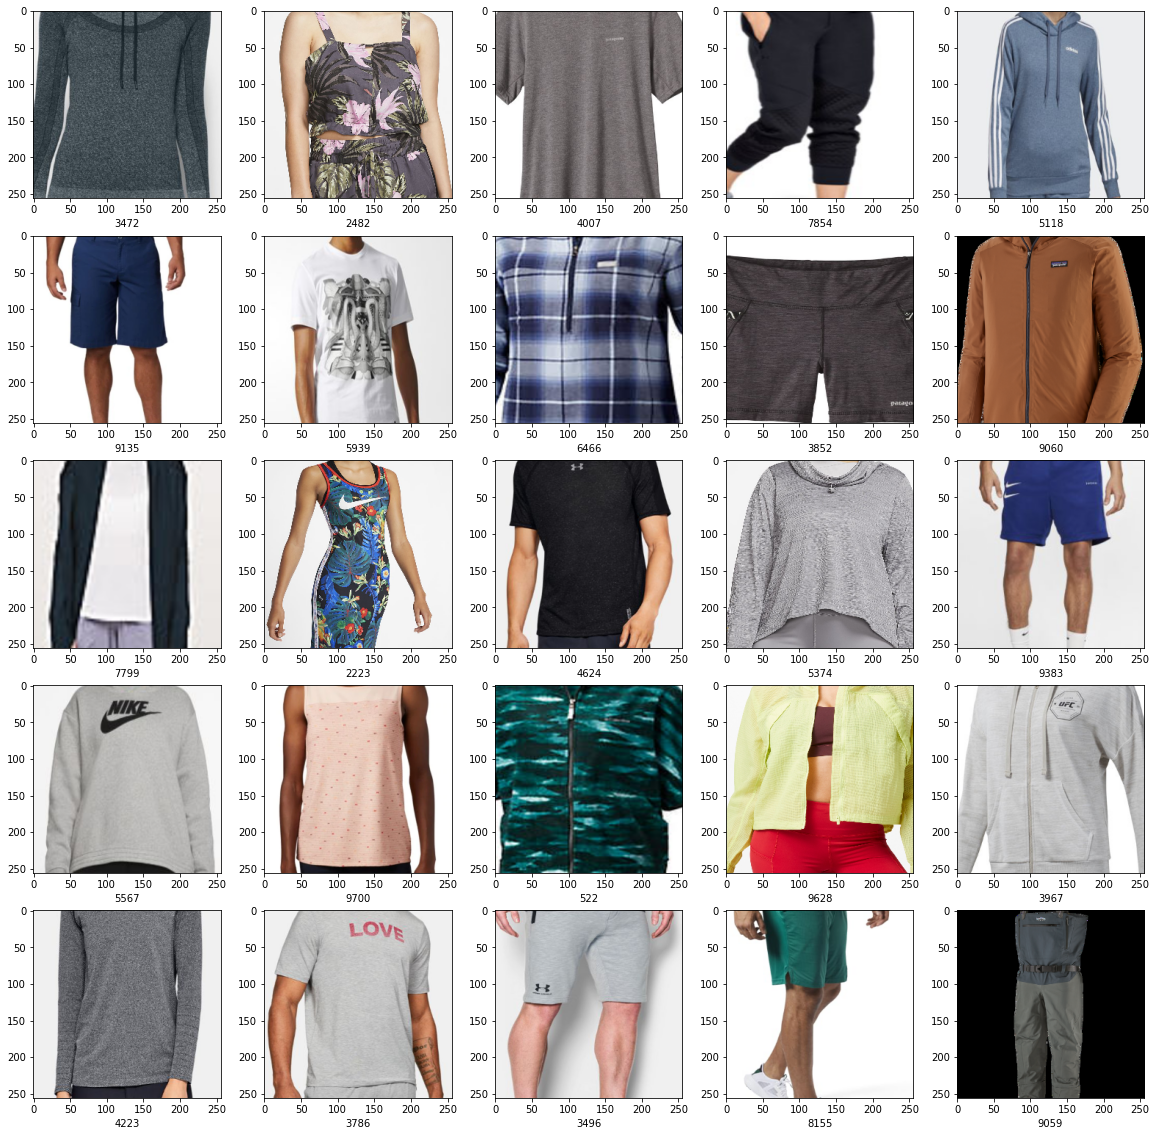

In [21]:
print("切割後的圖檔:")
# randomlist = random.sample(range(0, url_pattern_df.shape[0]), 25)
plt.figure(figsize=(20,20))
for i, df_index in enumerate(randomlist):
    plt.subplot(5,5,i+1)
    cur_image = url_pattern_df.loc[df_index]
    pattern = cur_image.pattern
    image_name = cur_image.image_name
    clothing = cur_image.clothing
    current_file = current_path + '/' + image_name + '.png'
    img = Image.open(current_file)
    img_ = np.array(img)
    if img_.ndim != 3:
        dimension_error_count += 1
        continue
    if img_.shape[2] == 4:  # 處理有 Transparency (RGBA) 的情況
        img = img.convert('RGB')
        img_ = np.array(img)
    img_, clothing_condition = cut_image(img_, clothing)
    plt.imshow(img_)
    plt.xlabel(df_index)
plt.show()

### 製作y label

In [22]:
# pict_nums = len(url_pattern_df)  # 目前已經不需要執行這個區塊了
# # y label 轉成 數值型態
# train_labels = []
# for i in url_pattern_df["pattern"].to_list()[:pict_nums]:
#     if i == "abstract":
#         train_labels.append(0)
#     elif i == "animal print":
#         train_labels.append(1)
#     elif i == "camouflage":
#         train_labels.append(2)
#     elif i == "floral":
#         train_labels.append(3)
#     elif i == "geometric":
#         train_labels.append(4)
#     elif i == "ikat":
#         train_labels.append(5)
#     elif i == "melange":
#         train_labels.append(6)
#     elif i == "placement":
#         train_labels.append(7)
#     elif i == "plaids":
#         train_labels.append(8)
#     elif i == "solid":
#         train_labels.append(9)
#     elif i == "spots":
#         train_labels.append(10)
#     elif i == "strips":
#         train_labels.append(11)
# train_labels = np.array(train_labels)
# print("train labels shape: ", train_labels.shape)

In [23]:
index2label = {
    0: "abstract",
    1: "animal print",
    2: "camouflage",
    3: "floral",
    4: "geometric",
    5: "ikat",
    6: "melange",
    7: "placement",
    8: "plaids",
    9: "solid",
    10: "spots",
    11: "strips",
}

In [24]:
# train labels to one-hot (目前沒使用到)
# train_labels_one_hot = to_categorical(train_labels, num_classes=12)
# print(train_labels_one_hot.shape)

### 標準化
這邊先用最簡單的除 255，目標希望可以讓模型更快收斂、圖像更清晰  
註:實測加上標準差之後有讓BaseCNN accuracy從 0.01~0.1 變成 0.3 真的有效  
但是 efficient net 已經有做標準化了，所以這裡不需要，反而會讓結果變得很糟 (0.6 -> 0.3)

In [25]:
# train_images = train_images / 255

In [26]:
# plt.imshow(train_images[0])
# plt.title('after normalization')
# plt.show()

### 切分訓練集、驗證集、測試集資料夾

In [110]:
# 複製一次 batch1_images_cut資料夾、新增一個資料夾，做一次就好
# 重新切分的話，要刪掉batch1_images_cut、batch1_images_cut_formal資料夾，重跑這格
# 注意不要刪掉batch1_images_cut_backup資料夾，就都還可以重跑
# shutil.copytree('./batch1_images_cut_backup', './batch1_images_cut')
# os.mkdir("./batch1_images_cut_formal")
# os.mkdir("./batch1_images_cut_formal/train")
# os.mkdir("./batch1_images_cut_formal/valid")
# os.mkdir("./batch1_images_cut_formal/test")

# for pattern in pattern_list:
#     os.mkdir("./batch1_images_cut_formal/train/{}".format(pattern))
#     os.mkdir("./batch1_images_cut_formal/valid/{}".format(pattern))
#     os.mkdir("./batch1_images_cut_formal/test/{}".format(pattern))

['abstract', 'animal print', 'camouflage', 'floral', 'geometric', 'ikat', 'melange', 'placement', 'plaids', 'solid', 'spots', 'strips']
abstract類有 1211 張圖片
train 有 726 張圖片
valid 有 242 張圖片
test 有 243 張圖片
abstract done

animal print


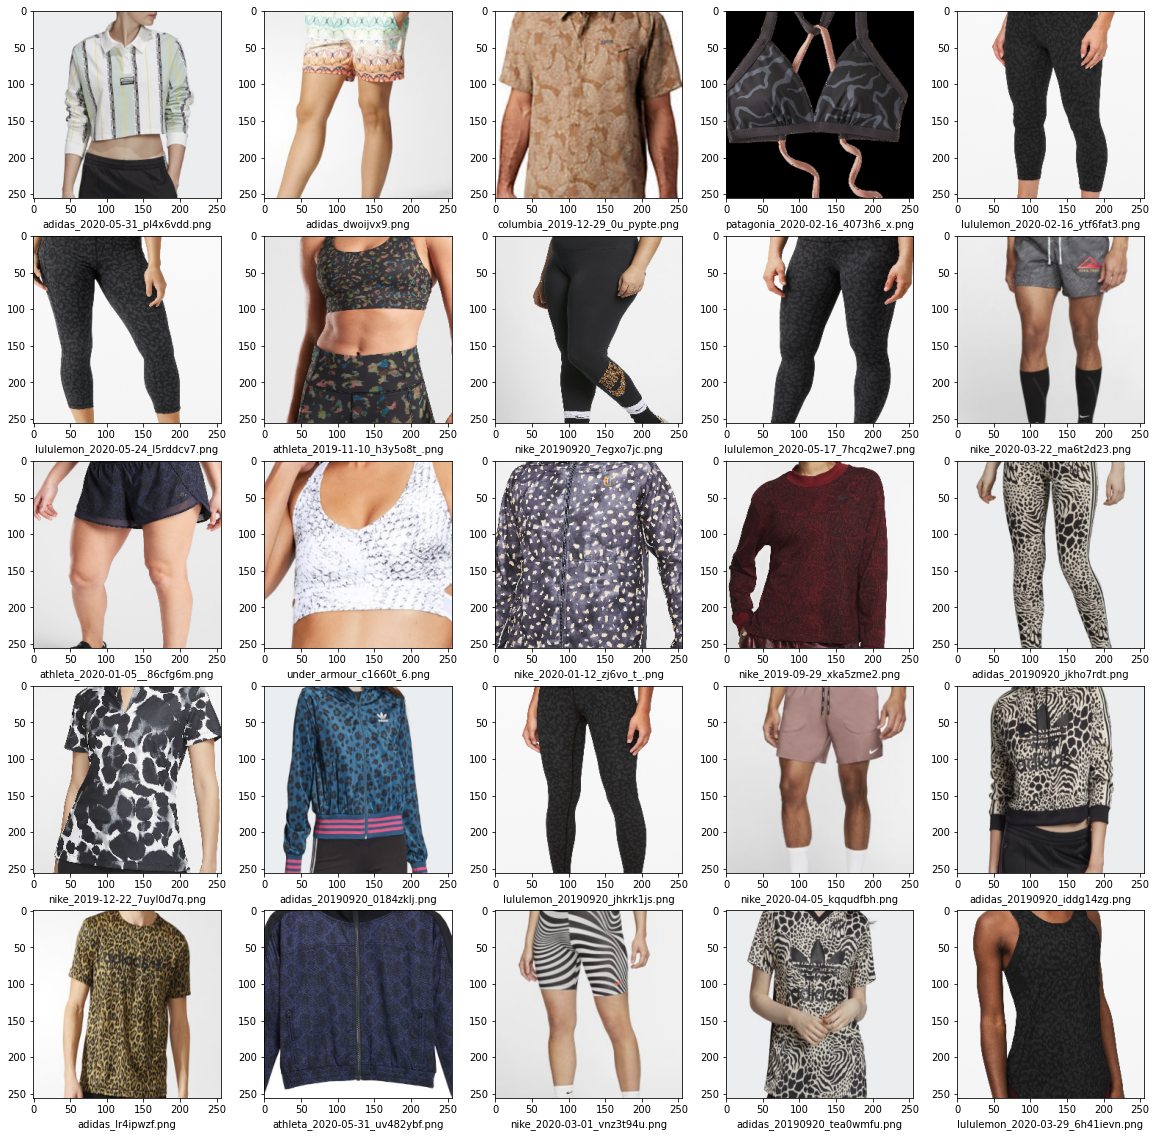

animal print類有 192 張圖片
train 有 115 張圖片
valid 有 38 張圖片
test 有 39 張圖片
animal print done

camouflage類有 510 張圖片
train 有 306 張圖片
valid 有 102 張圖片
test 有 102 張圖片
camouflage done

floral類有 509 張圖片
train 有 305 張圖片
valid 有 102 張圖片
test 有 102 張圖片
floral done

geometric類有 742 張圖片
train 有 445 張圖片
valid 有 148 張圖片
test 有 149 張圖片
geometric done

ikat類有 18 張圖片
train 有 10 張圖片
valid 有 4 張圖片
test 有 4 張圖片
ikat done

melange類有 2642 張圖片
train 有 1585 張圖片
valid 有 528 張圖片
test 有 529 張圖片
melange done

placement類有 469 張圖片
train 有 281 張圖片
valid 有 94 張圖片
test 有 94 張圖片
placement done

plaids類有 353 張圖片
train 有 211 張圖片
valid 有 71 張圖片
test 有 71 張圖片
plaids done

solid類有 2946 張圖片
train 有 1767 張圖片
valid 有 589 張圖片
test 有 590 張圖片
solid done

spots類有 38 張圖片
train 有 22 張圖片
valid 有 8 張圖片
test 有 8 張圖片
spots done

strips類有 712 張圖片
train 有 427 張圖片
valid 有 142 張圖片
test 有 143 張圖片
strips done



In [111]:
# # train:valid:test = 6:2:2
# cur_path = "./batch1_images_cut"
# all_directory_list = sorted(os.listdir(cur_path))
# print(all_directory_list)
# # random.seed(0)

# for d in all_directory_list:
#     cur_file_list = sorted(os.listdir(cur_path + "/{}".format(d)))
#     if cur_file_list[0] == '.ipynb_checkpoints':
#         cur_file_list.pop(0)
    
#     # 挑一個種類畫圖，可對照X_label檢查檔名。
#     if d == 'animal print':
#         randomlist = random.sample(range(0, len(cur_file_list)), 25)
#         print(d)
#         plt.figure(figsize=(20,20))
#         for i, index in enumerate(randomlist):
#             filename = cur_file_list[index]
#             cur_img_path = cur_path + '/{}/{}'.format(d, filename)

#             plt.subplot(5,5,i+1)
#             img = Image.open(cur_img_path)
#             img_ = np.array(img)
#             plt.imshow(img_)
#             plt.xlabel(filename)
#         plt.show()
        
#     # 存入新資料夾的train、valid、test中
#     # 作法就是隨機打亂 cur_file_list，前60%是train、中間20%是valid、後面20%是test
#     cur_file_list_copy = cur_file_list.copy()
#     random.shuffle(cur_file_list_copy)
#     percent_60 = int(len(cur_file_list_copy) * 0.6)
#     percent_80 = int(len(cur_file_list_copy) * 0.8)
    
#     train_filename = cur_file_list_copy[:percent_60]
#     valid_filename = cur_file_list_copy[percent_60:percent_80]
#     test_filename = cur_file_list_copy[percent_80:]
    
#     print("{}類有".format(d), len(cur_file_list_copy), "張圖片")
#     print("train 有", len(train_filename), "張圖片")
#     print("valid 有", len(valid_filename), "張圖片")
#     print("test 有", len(test_filename), "張圖片")
    
    
#     # 直接移動檔案
#     for file in train_filename:
#         shutil.move(cur_path + '/{}/{}'.format(d, file), './batch1_images_cut_formal/train/{}'.format(d))
        
#     for file in valid_filename:
#         shutil.move(cur_path + '/{}/{}'.format(d, file), './batch1_images_cut_formal/valid/{}'.format(d))
        
#     for file in test_filename:
#         shutil.move(cur_path + '/{}/{}'.format(d, file), './batch1_images_cut_formal/test/{}'.format(d))
        
#     # 檢查有沒有重複的檔名
#     for i in train_filename:
#         if i in valid_filename:
#             print("something wrong")
#         elif i in test_filename:
#             print("something wrong")
            
#     for i in valid_filename:
#         if i in test_filename:
#             print("something wrong")
        
#     print("{} done".format(d))
#     print()
